<h1>Multiple Linear Regression</h1>
This notebook is designed to explain and implement multiple linear regression in python, without the use of any machine learning libraries.

This cell will import all of our necessary libraries for the first part of the notebook: pandas, numpy, math, pyplot, and finally my own script simple_model_helper.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from simple_model_helper import predict, get_r_squared, get_rmse
np.random.seed(42)

# What is Multiple Linear Regression?

Multiple linear regression is another form of lienar regression that builds on top of simple linear regression. Recall that in the previous notebook, we explored simple linear regression, where we had one input variable (or feature) and we used this to predict one target variable. Multiple linear regression is exactly the same, except now we are using 2 or more features in order to predict one target variable. We know that the equation for simple linear regression was just essentially a linear line:
$$\hat{y} = w_{0} + x_{i}w_{1}$$
(with $\hat{y}$ = predicted value, $x_{i}$ = input values, $w_{1}$ = slope, $w_{0}$ = y-intercept)<br>
<br> The equation for multiple linear regression gets a little more complicated:
$$
\hat{y} = w_{0} + w_{1}x_{1} + w_{2}x_{2} + \ldots + w_{n}x_{n}
$$
Here, $\hat{y}$ remaisn as the predicted y value, and $w_{0}$ is still our intercept. However, now we have multiple input values, which  means we have the need for multiple coefficients in front of our input values, instead of just one, which would have been the slope for our line previously. So, the equation is essentially summing the products of all inputs (our $x_{n}$ values) and their coefficients (our $w_{n}$ values), then adding the intercept to predict $\hat{y}$.

## Data Overview

The dataset that we will be using to explore multiple linear regression can be found <a href="https://www.kaggle.com/datasets/yasserh/advertising-sales-dataset">here</a>. Lets have a look at our data:

In [2]:
df = pd.read_csv("./data/advertising-budgets.csv")
# In this line, we drop the first column (Unnamed: 0), it's just an extra index.
df = df.drop(columns="Unnamed: 0") 
df.head()

,TV Ad Budget ($),Radio Ad Budget ($),Newspaper Ad Budget ($),Sales ($)
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


For this dataset that we are using, its important to remember that for each of the feature columns, the data is in <u>thousands</u> of dollars. For the Sales column, the data is in <u>millions</u> of dollars. This won't affect how we build our model, but its important to think about when we evaluate it's performance.

First, lets see how well each of the three features (TV, Radio, and Newspaper) can calculate the projected sales on their own. I've created two bar plots below to show the RMSE and $R^2$ scores of each feature:

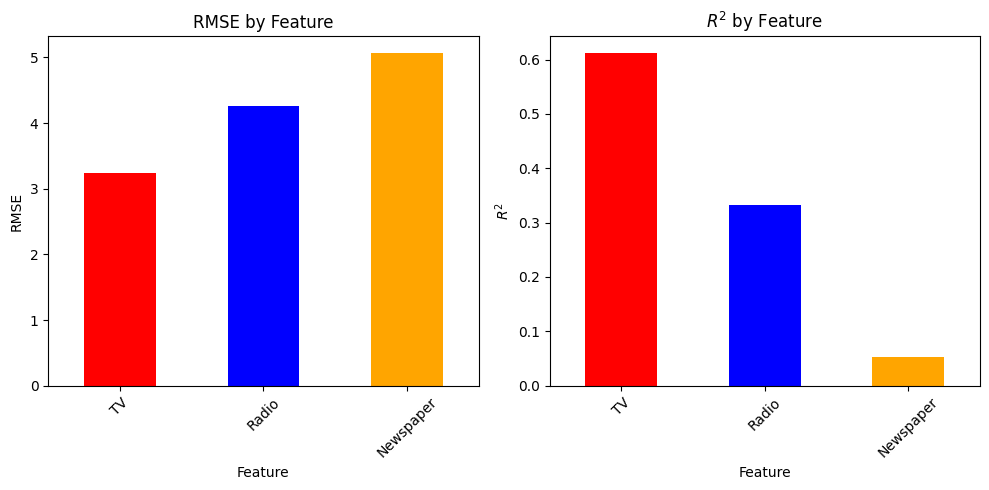

In [3]:
# Save the target column to its own reference, just for this graphing portion
y_simple = df["Sales ($)"]

features = {
    "TV": "TV Ad Budget ($)",
    "Radio": "Radio Ad Budget ($)",
    "Newspaper": "Newspaper Ad Budget ($)"
}

single_feature_data = []
for name, col in features.items():
    X = df[col]
    y_pred = predict(X, y_simple) # The script simple_model_helper handles the simple linear regression calculations for this notebook
    single_feature_data.append(
        {
            "Feature": name,
            "RMSE": get_rmse(y_simple, y_pred),
            "R^2": get_r_squared(y_simple, y_pred)
        }
    )

results_df = pd.DataFrame(single_feature_data).set_index("Feature")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

results_df["RMSE"].plot(kind="bar", ax=axes[0], color=["red", "blue", "orange"])
axes[0].set_title("RMSE by Feature")
axes[0].set_ylabel("RMSE")
axes[0].set_xticklabels(results_df.index, rotation = 45)

results_df["R^2"].plot(kind="bar", ax=axes[1], color=["red", "blue", "orange"])
axes[1].set_title(r"$R^2$ by Feature")
axes[1].set_ylabel(r"$R^2$")
axes[1].set_xticklabels(results_df.index, rotation = 45)

plt.tight_layout()
plt.show()

As you can see, from the above graphs, the metrics for each individual feature's performance don't look great. The best one is TV, which is off around 3 million dollars for each prediction, and it has a small $R^2$ of about 0.6. The two other features do even worse. So, clearly using individual features with simple regression is not a great approach for this data.

## Model Implementation

To start, we split our dataframe into X and y, exactly like we did with simple linear regression:

In [4]:
X = df[["TV Ad Budget ($)", "Radio Ad Budget ($)", "Newspaper Ad Budget ($)"]]
y = df["Sales ($)"]

Already, there are changes to the process. We need to add a column of ones to our feature matrix, so that we can include the intercepts for each summation when we are predicting. Otherwise, we will have to include the intercepts seperately, which can be annoying. We can add our column of ones using np.c_[np.ones(...)] to fill a new collumn with only ones, and have it be the "leftmost" in our feature matrix.

In [5]:
X_b = np.c_[np.ones((X.shape[0], 1)), X]

Previously, when covering the equation for multiple linear regressions, I mentioned that <u>feature has its own coefficient</u>. These coefficients can be calculated by using the "normal equation", which is: $$W = (X^T X)^{-1} X^T y$$In this equation, you are finding the <b>inverse</b> of the following: $X$ transposed, multiplied by $X$. Then, multiply that matrix by $X$ transposed once more. Lastly, multiply that by the vector $y$. This will give you $W$, which is the vector that contains all of our coefficients! ($w_{0}, w_{1}, \ldots, w_{n}$) Finally, take the first value in that vector ($w_{0}$, remember that column of ones that we added? This intercept corresponds to that column!) and make that your intercept, with the rest of the values being the coefficients for their corresponding input value.

In [6]:
coefficients = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
intercept = coefficients[0]
coefficients = coefficients[1:]
print(intercept, coefficients)

2.938889369459438 [ 0.04576465  0.18853002 -0.00103749]


You can have a look at the intercept as well as the coefficients above: In everyday terms, these coefficients are basically saying that for every 1,000 dollars spent in the corresponding category, then the target value (Sales) increases by 1,000,000 dollars * the coefficient.

Now that we have our coefficients, we are ready to make our predictions! In code, this is actually fairly simple. The following code cell performs matrix multiplication across the input values matrix as well as our vector of coefficients. Then, it adds the intercept to each predicted value in the y_predictions vector.

In [7]:
y_predictions = intercept + np.dot(X, coefficients)

## Performance Analysis

When graphing our results, we have to go about this a little bit differently. Most importandly, we can't graph a "best fit" line to show our predictions, since we have multiple different slopes/coefficients. Instead, we will graph points on a scatter plot with the predicted sales value for a point being on the y axis, with the actual sales value being on the x axis. Then, we will add a $45^\circ$ line through the graph. Because of how we graphed our points, this line acts as the "perfect predictor" line. Any point that falls directly on this graph has an equal x and y value, meaning that the value perfectly predicted the sales amount!

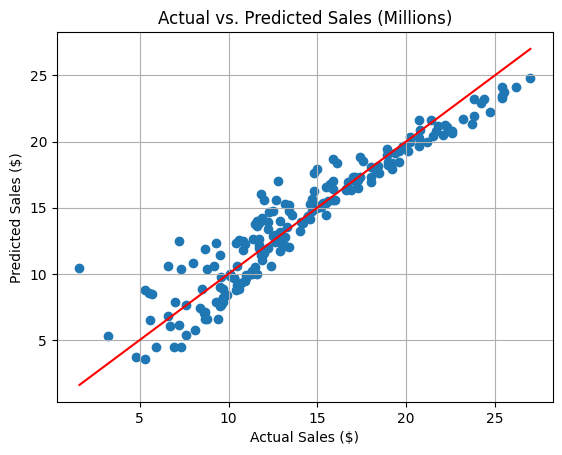

In [8]:
plt.scatter(y, y_predictions)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red")
plt.xlabel("Actual Sales ($)")
plt.ylabel("Predicted Sales ($)")
plt.title("Actual vs. Predicted Sales (Millions)")
plt.grid()
plt.show()

Looking at this graph, it looks as if our model did a great job! Now, lets compute some metrics. For multiple linear regression, the equation for $R^2$ score is as follows:<br>
$$
R^2 = 1 - \frac{\sum_{i}(y_{i} - \hat{y}_{i})^2}{\sum_{i}(y_{i} - \bar{y}_{i})^2}
$$
As before, $y_{i}$ is our target values, $\hat{y}_{i}$ are our predicted values, and $\bar{y}$ is the mean of our target values.

In [9]:
multiple_r_squared = 1 - np.sum((y - y_predictions) ** 2) / np.sum((y - np.mean(y)) ** 2)
print(multiple_r_squared)

0.8972106381789522


Next, lets calculate MSE and RMSE. The formula for this is the same as it was for simple linear regression:<br>
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^2$$

In [10]:
multiple_mse = 1 / len(X) * np.sum((y - y_predictions) ** 2)
multiple_rmse = math.sqrt(multiple_mse)
multiple_rmse

1.6685701407225697

Another way to gauge performance is to have a look at the <u>residual plot</u> of the graph. The residual of a data point is easily calculated by the following:
$$
e = y_{i} - \hat{y}_{i}
$$
Since the residual is the difference between $y_{i}$ and $\hat{y}_{i}$, we can find ALL of the residuals by just subtracting our input value vector and the predicted value vector:

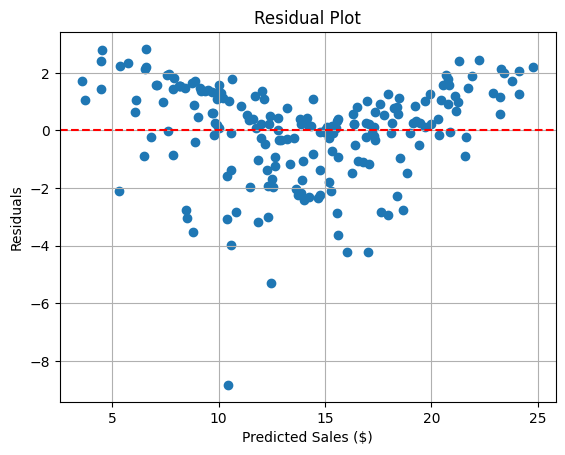

In [11]:
residuals = y - y_predictions
plt.scatter(y_predictions, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Sales ($)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid()
plt.show()

The above residual plot shows that our results are clustered around 0, but they also seem to follow a pattern: a slight u-shaped wave dipping around 15, and then rising again. While this doesn't completely invalidate our model, it shows that it may have a weakness when assuming linearity between the target and one or more of the features. However, this is still important to our model and this project! Machine Learning is about <b>learning</b> (it's in the name) and no model is going to be perfect at first.

## Final Comparison

Already, we can tell that these values are proving that our model using all of the features as predictors of sales is MUCH stronger than any individual feature was. Lets graph this relationship:

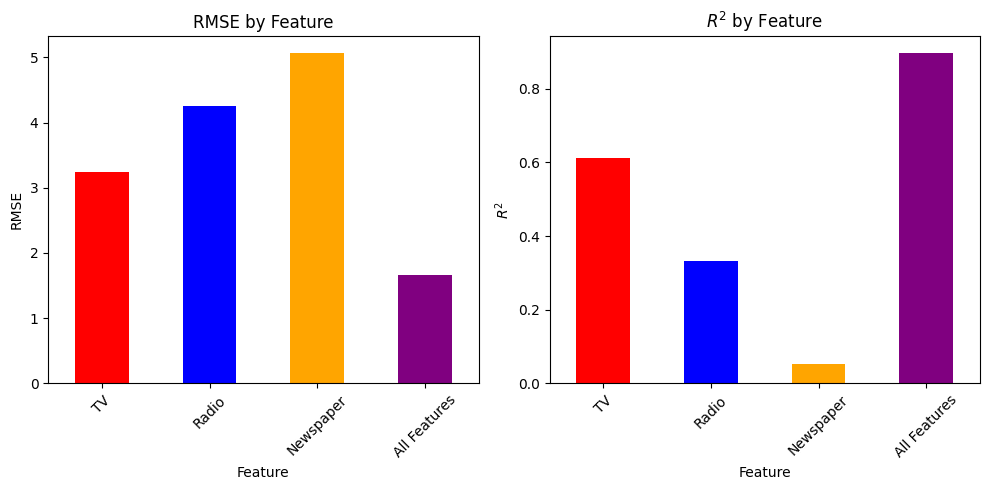

In [12]:
results_df.loc["All Features", "R^2"] = multiple_r_squared
results_df.loc["All Features", "RMSE"] = multiple_rmse
colors = ["red", "blue", "orange", "purple"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

results_df["RMSE"].plot(kind="bar", ax=axes[0], color=colors)
axes[0].set_title("RMSE by Feature")
axes[0].set_ylabel("RMSE")
axes[0].set_xticklabels(results_df.index, rotation = 45)

results_df["R^2"].plot(kind="bar", ax=axes[1], color=colors)
axes[1].set_title(r"$R^2$ by Feature")
axes[1].set_ylabel(r"$R^2$")
axes[1].set_xticklabels(results_df.index, rotation = 45)

plt.tight_layout()
plt.show()

As you can see, our multiple linear regression model performs FAR better for both metrics than the individual features do.